# BERT Extensions

This notebook will develop additional topics related BERT and modern language models.

1. HuggingFace's model hub: finding models finetuned for a variety of tasks.
    - Similarity between sentences: [*Sentence BERT*](https://www.sbert.net/index.html)
    - Sentiment analysis: [Twitter roBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)

2. Interpretability

# Setup

In [1]:
# Instructions for Colab: 
# 1. First CHANGE RUNTIME TYPE to GPU 
# 2. Then run install commands commented out below
# 3. You might need to RESTART RUNTIME
# 4. Run git clone command to the get files from the public repository
# 5. Run the rest of the cells below

In [4]:
# install required libraries
!pip3 install transformers                  # HuggingFace library for interacting with BERT (and multiple other models)
!pip3 install datasets                      # HuggingFace library to process dataframes
!pip3 install sentence-transformers         # library to use Sentence Similarity BERT
!pip3 install bertviz                       # visualize BERT's attention weigths
!pip3 install annoy                         # Spotify's library for finding nearest neighbours
!pip3 install pyyaml==5.4.1                 # required for plotly express (interactive plots)                     
!pip3 install shap                          # library for interpreting language models
!pip3 install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 33.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# (COLAB) you might need to restart RUNTIME after installing packages!

In [6]:
import pandas as pd
import numpy as np
import gdown
import random
from tqdm.auto import tqdm
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from annoy import AnnoyIndex
from scipy import spatial

from transformers import BertModel, AutoTokenizer, BertForSequenceClassification, pipeline, TrainingArguments, Trainer, utils
from transformers.pipelines.base import KeyDataset
from datasets import load_dataset, load_metric, Dataset, DatasetDict

from sentence_transformers import SentenceTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import shap

# test GPU
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


In [7]:
# define paths and seed
seed = 92
data_path = "./"

In [8]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10k_sent_2019":        ("https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX", "parquet"),
                 "covariates_2019":      ("https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4", "csv"),
                 "naics2_codes":         ("https://drive.google.com/uc?id=1H4bFNVbEbhxQotoxsM3yf-JrtgKGXG0k", "csv")
                  }

In [9]:
# download each file in the dictionary
for file_name, attributes in data_url_dict.items():
  url = attributes[0]
  extension = attributes[1]
  gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=17PQbZ6EotMxyhpt2Laqqh9z-EKUbwDhX
To: /content/10k_sent_2019.parquet
100%|██████████| 162M/162M [00:04<00:00, 38.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ELRq69FOiFvNpSvXOijGeGKZB5DiNXt4
To: /content/covariates_2019.csv
100%|██████████| 428k/428k [00:00<00:00, 55.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1H4bFNVbEbhxQotoxsM3yf-JrtgKGXG0k
To: /content/naics2_codes.csv
100%|██████████| 868/868 [00:00<00:00, 188kB/s]


# Load data

In [10]:
# read data
df = pd.read_parquet(data_path + "10k_sent_2019.parquet")
df

,sentences,cik,year,sent_no,sent_id
0,You should carefully review the following disc...,1065088,2019,0,1065088_0
1,"Risk Factors That May Affect our Business, Res...",1065088,2019,1,1065088_1
2,Our operating and financial results are subjec...,1065088,2019,2,1065088_2
3,Our operating and financial results have varie...,1065088,2019,3,1065088_3
4,It is difficult for us to forecast the level o...,1065088,2019,4,1065088_4
...,...,...,...,...,...
1744126,,1069533,2019,189,1069533_189
1744127,The Company is generally isolated from commodi...,1069533,2019,190,1069533_190
1744128,,1069533,2019,191,1069533_191
1744129,"With respect to interest rate risk, the Compan...",1069533,2019,192,1069533_192


In [11]:
# firm-level data
covariates = pd.read_csv(data_path + "covariates_2019.csv")
covariates.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,1004,20200531,2019,INDL,C,D,STD,AIR,AAR CORP,USD,1438.700,2079.000,5.400,1750,A,423860,42,Wholesale Trade
1,1050,20191231,2019,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,USD,179.498,408.637,0.830,3197,A,333413,33,Manufacturing
2,1078,20191231,2019,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,15667.000,67887.000,107.000,1800,A,334510,33,Manufacturing
3,1104,20191231,2019,INDL,C,D,STD,ACU,ACME UNITED CORP,USD,73.146,110.749,0.441,2098,A,332215,33,Manufacturing
4,1117,20191231,2019,INDL,C,D,STD,BKTI,BK TECHNOLOGIES CORP,USD,23.886,37.940,0.111,2186,A,334220,33,Manufacturing


In [12]:
# we will choose some specific firms of interest using their TIC identifiers
tics = ["AAPL", "GOOGL", "TWTR", "ORCL", "TSLA", "GM", "F", "BAC", "COF", "JPM", "AXP", "HBC2", "TGT", "M", "WMT", "COST", "BNED", "DIS", "FOXA", "ADSK", "CAT", "BA"]
covariates_focus = covariates.loc[covariates["tic"].isin(tics)]
covariates_focus = covariates_focus.groupby("tic", as_index=False).max()
covariates_focus

,tic,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,conm,curcd,act,at,emp,cik,costat,naics,naics2,naics2_name
0,AAPL,1690,20190930,2019,INDL,C,D,STD,APPLE INC,USD,162819.000,338516.000,137.000,320193,A,334220,33,Manufacturing
1,ADSK,1878,20200131,2019,INDL,C,D,STD,AUTODESK INC,USD,2659.300,6179.300,10.100,769397,A,519130,51,Information
2,AXP,1447,20191231,2019,INDL,C,D,STD,AMERICAN EXPRESS CO,USD,NaN,198321.000,64.500,4962,A,522210,52,Finance and Insurance
3,BA,2285,20191231,2019,INDL,C,D,STD,BOEING CO,USD,102229.000,133625.000,161.100,12927,A,336411,33,Manufacturing
4,BAC,7647,20191231,2019,INDL,C,D,STD,BANK OF AMERICA CORP,USD,NaN,2434079.000,208.131,70858,A,522110,52,Finance and Insurance
5,BNED,23208,20200430,2019,INDL,C,D,STD,BARNES & NOBLE EDUCATION INC,USD,584.919,1156.432,5.500,1634117,A,451211,45,Retail Trade
6,CAT,2817,20191231,2019,INDL,C,D,STD,CATERPILLAR INC,USD,39193.000,78453.000,102.300,18230,A,333120,33,Manufacturing
7,COF,30990,20191231,2019,INDL,C,D,STD,CAPITAL ONE FINANCIAL CORP,USD,NaN,390365.000,51.900,927628,A,522210,52,Finance and Insurance
8,COST,29028,20190831,2019,INDL,C,D,STD,COSTCO WHOLESALE CORP,USD,23485.000,45400.000,254.000,909832,A,452311,45,Retail Trade
9,DIS,3980,20190930,2019,INDL,C,D,STD,DISNEY (WALT) CO,USD,28124.000,193984.000,223.000,1744489,A,515120,51,Information


In [13]:
# look at their 2 digit NAICS sector code
covariates_focus.groupby("naics2").size()

naics2
33    6
45    5
51    6
52    5
dtype: int64

In [14]:
# generate a dictionary mapping from CIK to name
cik2name = {row["cik"]: row["conm"] for i, row in covariates_focus.iterrows()}
cik2name

{320193: 'APPLE INC',
 769397: 'AUTODESK INC',
 4962: 'AMERICAN EXPRESS CO',
 12927: 'BOEING CO',
 70858: 'BANK OF AMERICA CORP',
 1634117: 'BARNES & NOBLE EDUCATION INC',
 18230: 'CATERPILLAR INC',
 927628: 'CAPITAL ONE FINANCIAL CORP',
 909832: 'COSTCO WHOLESALE CORP',
 1744489: 'DISNEY (WALT) CO',
 37996: 'FORD MOTOR CO',
 1754301: 'FOX CORP',
 1467858: 'GENERAL MOTORS CO',
 1652044: 'ALPHABET INC',
 83246: 'HSBC USA INC',
 19617: 'JPMORGAN CHASE & CO',
 794367: "MACY'S INC",
 1341439: 'ORACLE CORP',
 27419: 'TARGET CORP',
 1318605: 'TESLA INC',
 1418091: 'TWITTER INC',
 104169: 'WALMART INC'}

In [15]:
# select the 10K reports from the selected firms
df = df.loc[df["cik"].isin(covariates_focus["cik"])]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id
0,The following discussion sets forth the materi...,19617,2019,0,19617_0
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2
3,Regulatory,19617,2019,3,19617_3
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4
...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197


In [16]:
# lets explore a random sentence
i = np.random.randint(0, len(df))
print(f"Sentence from: {cik2name[df.loc[i, 'cik']]}")
print(df.loc[i, "sentences"])

Sentence from: MACY'S INC
Our inability to do so could negatively affect our cash flows, financial condition and results of operations.


In [17]:
# merge each sentence with the NAICS2 code from its corresponding firm
df = pd.merge(df, covariates_focus[["cik", "naics2"]], how="left", on="cik")
df

,sentences,cik,year,sent_no,sent_id,naics2
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52
3,Regulatory,19617,2019,3,19617_3,52
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52
...,...,...,...,...,...,...
7279,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51
7280,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51
7281,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51
7282,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51


In [18]:
# drop potentially empty sentences or sentences of very few words
min_words = 3
df["sentence_len"] = df["sentences"].apply(lambda x: len(x))
df["keep_sent"] = df["sentence_len"].apply(lambda x: x > min_words)
df = df.loc[df["keep_sent"]]
df.reset_index(drop=True, inplace=True)
df

,sentences,cik,year,sent_no,sent_id,naics2,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,132,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,133,True
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,389,True
3,Regulatory,19617,2019,3,19617_3,52,10,True
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,165,True
...,...,...,...,...,...,...,...,...
6876,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,132,True
6877,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,154,True
6878,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,102,True
6879,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,147,True


In [19]:
# load NAICS2 codes and names
df_naics = pd.read_csv(data_path + "naics2_codes.csv")

In [20]:
# transform dataframe into Dataset class (easier to work with pipeline)
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['sentences', 'cik', 'year', 'sent_no', 'sent_id', 'naics2', 'sentence_len', 'keep_sent'],
    num_rows: 6881
})

# Online models

## Sentence similarity

In [21]:
# load sentence embedding model from Huggingface
# list of all available models here: https://www.sbert.net/docs/pretrained_models.html
model_sent = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model_sent

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [22]:
# test the model by embedding two similar sentences
sent_a = "We are highly exposed to volatility from the currency markets."
sent_b = "Our firm holds multiple currencies and can be affected by fluctuations in that market."
sent_emb_a = model_sent.encode(sent_a)
sent_emb_b = model_sent.encode(sent_b)
print(sent_emb_a.shape, sent_emb_b.shape)

# calculate the cosine similarity between the two embedded representations
cos_sim = 1- spatial.distance.cosine(sent_emb_a, sent_emb_b)
print(f"Cosine similarity between sentences: {cos_sim}")

(768,) (768,)
Cosine similarity between sentences: 0.6639918088912964


In [23]:
# test the model by embedding two different sentences
sent_a = "We are highly exposed to volatility from the currency markets."
sent_b = "Our sales have grown constantly each quarter."
sent_emb_a = model_sent.encode(sent_a)
sent_emb_b = model_sent.encode(sent_b)
print(sent_emb_a.shape, sent_emb_b.shape)

# calculate the cosine similarity between the two embedded representations
cos_sim = 1- spatial.distance.cosine(sent_emb_a, sent_emb_b)
print(f"Cosine similarity between sentences: {cos_sim}")

(768,) (768,)
Cosine similarity between sentences: 0.28047850728034973


In [24]:
# get embedded representations for all sequences
all_sent_emb = []
for sent in tqdm(df["sentences"].values):
    all_sent_emb.append(model_sent.encode(sent))

all_sent_emb = np.array(all_sent_emb)

  0%|          | 0/6881 [00:00<?, ?it/s]

In [25]:
def build_indexer(vectors, num_trees=10):
    """ we will use a version of approximate nearest neighbors
        (ANNOY: https://github.com/spotify/annoy) to build an indexer
        of the sequence embeddings matrix
    """
    
    # angular = cosine
    indexer = AnnoyIndex(vectors.shape[1], 'angular')
    for i, vec in enumerate(vectors):
        # add word embedding to indexer
        indexer.add_item(i, vec)
        
    # build trees for searching
    indexer.build(num_trees)
    
    return indexer

In [26]:
# create an indexer for all our estimated sentence embeddings
indexer_emb = build_indexer(all_sent_emb, 1000)

In [30]:
# select a random sentence
sent_position = 23
sent = df.loc[sent_position, "sentences"]
print(sent)

Differences in financial services regulation can be disadvantageous for JPMorgan Chase's business.


In [31]:
# find the top-n nearest neighbours to the target sequence
cls_nns, cls_dists = indexer_emb.get_nns_by_item(sent_position, n=5, include_distances=True)

# print results
for nn_idx, dist in zip(cls_nns, cls_dists):
    print(f"Cosine similarity between sentence and target: {1- dist}")
    print(df.loc[nn_idx, "sentences"])
    print("\n-------\n")

Cosine similarity between sentence and target: 1.0
Differences in financial services regulation can be disadvantageous for JPMorgan Chase's business.

-------

Cosine similarity between sentence and target: 0.3817752003669739
These types of differences in the regulatory framework can result in a firm such as JPMorgan Chase losing market share to competitors that are less regulated or not subject to regulation, especially with respect to unregulated financial products.

-------

Cosine similarity between sentence and target: 0.35355323553085327
JPMorgan Chase's businesses are highly regulated, and the laws and regulations that apply to JPMorgan Chase have a significant impact on its business and operations.

-------

Cosine similarity between sentence and target: 0.3118124008178711
These changes could result in JPMorgan Chase incurring additional costs for complying with laws and regulations and could reduce JPMorgan Chase's profitability.

-------

Cosine similarity between sentence an

In [32]:
# the target sentence does not have to be in the corpus!
outside_target = "We are highly exposed to volatility from the currency markets."
outside_emb = model_sent.encode(outside_target)

In [33]:
# find the top-n nearest neighbours to the target sequence
out_nns, out_dists = indexer_emb.get_nns_by_vector(outside_emb, n=6, include_distances=True)

# print results
for nn_idx, dist in zip(out_nns, out_dists):
    print(f"Cosine similarity between sentence and target: {1- dist}")
    print(df.loc[nn_idx, "sentences"])
    print("\n-------\n")

Cosine similarity between sentence and target: 0.19929510354995728
Volatility in global financial markets may also limit our ability to access the capital markets at a time when we would like, or need, to raise capital, which could have an impact on our ability to react to changing economic and business conditions.

-------

Cosine similarity between sentence and target: 0.187941312789917
• fluctuating currency exchange rates, including devaluations, currency controls and inflation, and risks related to any hedging activities we undertake;

-------

Cosine similarity between sentence and target: 0.18664461374282837
We may experience foreign currency gains and losses.

-------

Cosine similarity between sentence and target: 0.1817135214805603
We are exposed to fluctuations in currency exchange rates, which could negatively affect our financial results.

-------

Cosine similarity between sentence and target: 0.1802622675895691
As we continue to expand internationally, our exposure to fl

### Most similar firms

We could take this analysis one step further and generate an embedded representation for each firm based on all its sentences and then find the firms with the most similar representations.

In [34]:
all_sent_emb.shape, df.shape

((6881, 768), (6881, 8))

In [35]:
# build a dataframe with the features obtained using sentence embeddings
df_features_sent = pd.DataFrame(all_sent_emb)
df_features_sent

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.011817,0.011453,0.011278,0.009599,0.065816,0.051294,-0.011161,-0.001203,-0.057753,0.001920,...,-0.077610,0.002371,0.051753,0.024290,-0.015564,-0.135904,0.020548,0.015652,-0.004299,-0.036282
1,-0.015233,0.028815,-0.017432,0.037591,0.011595,0.017166,0.074671,0.019215,0.021796,0.001575,...,-0.051599,-0.022396,-0.082621,-0.046256,-0.049867,-0.082608,-0.019138,-0.001914,0.022236,-0.038196
2,-0.026442,0.026214,-0.006620,-0.005092,0.050608,0.063110,-0.018622,0.018449,-0.065425,0.005702,...,-0.055689,-0.000722,0.031532,0.036150,-0.040938,-0.099203,0.032251,-0.003874,0.019218,-0.042799
3,0.019198,0.016163,-0.016420,-0.001882,0.023558,-0.012434,0.000541,0.008629,-0.016590,-0.000131,...,-0.042594,-0.008370,-0.013988,0.000060,-0.015393,0.003064,-0.034657,0.025717,-0.032194,0.008357
4,0.034214,0.044039,-0.002761,-0.032364,0.057897,0.008970,0.007638,0.011436,-0.006285,-0.004822,...,-0.063936,0.027796,0.062791,-0.002406,-0.001966,-0.093930,-0.019117,0.032081,0.028137,-0.006739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6876,0.000095,-0.016173,0.020436,0.010461,0.015649,0.013981,-0.072255,0.024676,-0.000678,-0.053130,...,-0.093776,-0.001394,-0.017165,0.031219,0.020396,0.021740,0.031515,-0.017126,-0.063337,0.023777
6877,0.015674,0.042853,-0.034396,-0.071674,0.045786,0.023405,-0.035900,0.061967,0.032311,-0.014177,...,-0.018045,0.001670,-0.003966,0.043865,-0.007955,-0.034968,0.076045,-0.014369,-0.014035,-0.030880
6878,0.010755,0.018237,-0.019800,0.002902,0.049219,0.012570,-0.049772,0.037785,-0.020872,-0.006634,...,-0.058688,0.007294,-0.029078,0.049130,-0.020713,-0.038941,0.062150,-0.039018,-0.025081,0.005752
6879,0.031607,0.026091,-0.004579,-0.045578,0.029132,0.030749,-0.002315,0.037723,-0.034652,-0.037827,...,-0.063526,0.005702,0.021538,0.040555,-0.027343,-0.042495,0.013669,-0.056975,0.009584,-0.041691


In [36]:
# generate the average embedding for each firm
df_complete = pd.merge(df[["cik"]], df_features_sent, left_index=True, right_index=True)
df_complete = df_complete.groupby("cik").mean()
df_complete

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
cik,,,,,,,,,,,,,,,,,,,,,
4962,0.019879,0.026010,-0.019184,-0.018643,0.014444,0.020973,0.008990,0.006543,-0.005482,-0.009186,...,-0.024711,-0.001085,0.011852,0.025457,-0.007650,-0.028705,-0.005007,-0.000991,-0.004378,-0.018492
12927,0.014889,0.043955,-0.014420,-0.018629,0.010913,0.006485,0.015975,-0.004587,-0.019312,-0.013643,...,-0.022944,-0.004812,0.002866,0.022198,0.005148,-0.033182,-0.005692,0.005949,-0.015031,-0.020584
18230,0.009545,0.033432,-0.019373,-0.019451,0.013866,0.013823,0.006068,0.001337,-0.000241,-0.002001,...,-0.023809,-0.005075,0.004359,0.024514,-0.000116,-0.037845,-0.004413,0.002651,-0.016095,-0.014163
19617,0.019366,0.012555,-0.009703,-0.021122,0.017882,0.014847,0.024120,0.020049,0.006171,0.008146,...,-0.059114,0.026150,0.016931,0.005887,-0.008116,-0.044017,0.002030,0.008744,-0.011525,-0.004436
27419,0.011736,0.038427,-0.024547,-0.013873,0.003866,0.014775,0.011744,-0.013565,-0.010177,-0.017785,...,-0.013274,-0.001922,0.000495,0.025744,-0.002860,-0.024002,-0.021517,-0.004003,-0.001798,-0.024701
37996,-0.003947,0.018381,-0.016261,-0.004153,0.013045,0.006673,0.013499,0.010266,-0.010169,-0.017162,...,-0.021296,0.003914,0.015724,0.018043,0.003121,-0.012053,-0.014143,0.000712,-0.019600,-0.017250
70858,0.010047,0.010054,-0.020826,-0.026940,0.012180,0.021798,0.007021,0.008473,0.000545,-0.001835,...,-0.035201,-0.003135,0.009956,0.029436,-0.002230,-0.031900,0.000249,0.000603,-0.017264,-0.011452
83246,0.010073,0.008181,-0.017116,-0.029392,0.007031,0.022633,0.003682,0.008115,0.007667,0.000462,...,-0.032704,0.002551,0.003105,0.026668,-0.004158,-0.029747,-0.002009,0.001843,-0.025704,-0.011297
104169,0.015422,0.032270,-0.020704,-0.016457,0.005650,0.019662,0.022668,-0.008831,-0.006591,-0.020091,...,-0.017040,0.005023,0.001879,0.025998,-0.001303,-0.037612,-0.017140,-0.004030,-0.018206,-0.023556


In [37]:
# transform features into numpy array
firm_features = df_complete.to_numpy()
firm_features.shape

(22, 768)

In [38]:
# create an indexer for the firm embeddings
indexer_firms = build_indexer(firm_features, 1000)

In [39]:
idx2name = {i: cik2name[code] for i,code in enumerate(list(df_complete.index))}
idx2name

{0: 'AMERICAN EXPRESS CO',
 1: 'BOEING CO',
 2: 'CATERPILLAR INC',
 3: 'JPMORGAN CHASE & CO',
 4: 'TARGET CORP',
 5: 'FORD MOTOR CO',
 6: 'BANK OF AMERICA CORP',
 7: 'HSBC USA INC',
 8: 'WALMART INC',
 9: 'APPLE INC',
 10: 'AUTODESK INC',
 11: "MACY'S INC",
 12: 'COSTCO WHOLESALE CORP',
 13: 'CAPITAL ONE FINANCIAL CORP',
 14: 'TESLA INC',
 15: 'ORACLE CORP',
 16: 'TWITTER INC',
 17: 'GENERAL MOTORS CO',
 18: 'BARNES & NOBLE EDUCATION INC',
 19: 'ALPHABET INC',
 20: 'DISNEY (WALT) CO',
 21: 'FOX CORP'}

In [41]:
# find the top-n nearest neighbours to the target sequence
target_firm = 5
firm_nns, firm_dists = indexer_firms.get_nns_by_item(target_firm, n=4, include_distances=True)

# print results
print(f"NNs to: {idx2name[target_firm]} \n\n")
for i, (nn_idx, dist) in enumerate(zip(firm_nns, firm_dists)):
    if i > 0:
        print(idx2name[nn_idx])
        print(f"Cosine similarity between firms: {1 - dist}")
        print("\n-------")

NNs to: FORD MOTOR CO 


GENERAL MOTORS CO
Cosine similarity between firms: 0.6492211520671844

-------
TESLA INC
Cosine similarity between firms: 0.5701983571052551

-------
CATERPILLAR INC
Cosine similarity between firms: 0.5303983092308044

-------


In [43]:
#%%

# we can also use a dimension reduction technique to plot these embedded
# representation of firms in 2 dimensions

#==================
# PCA
#==================

pca = PCA(n_components=2)
pca.fit(firm_features)
features_pca = pca.transform(firm_features)
print(f"Variance explained by each component: {pca.explained_variance_}")

#%%

#==================
# TSNE
#==================

features_tsne = TSNE(n_components=2,
                    perplexity=2,
                    learning_rate='auto', 
                    init='random', 
                    metric="cosine").fit_transform(firm_features)


# consolidate features in a single dataframe
df_plot = pd.DataFrame({"cik": df_complete.index, "firm_name": idx2name.values(),
                        "pca1": features_pca[:, 0], "pca2": features_pca[:, 1],
                        "tsne1": features_tsne[:, 0], "tsne2": features_tsne[:, 1]
                        })

# join with NAICS2 data
df_plot = pd.merge(df_plot, df[["cik", "naics2"]], on="cik", how="left")
df_plot["naics2_name"] = df_plot["naics2"].apply(lambda x: df_naics.loc[df_naics["Sector"] == x]["Description"].values[0])
df_plot

Variance explained by each component: [0.00964129 0.00632637]


'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


,cik,firm_name,pca1,pca2,tsne1,tsne2,naics2,naics2_name
0,4962,AMERICAN EXPRESS CO,0.055361,-0.023846,-74.958588,36.784229,52,Finance and Insurance
1,4962,AMERICAN EXPRESS CO,0.055361,-0.023846,-74.958588,36.784229,52,Finance and Insurance
2,4962,AMERICAN EXPRESS CO,0.055361,-0.023846,-74.958588,36.784229,52,Finance and Insurance
3,4962,AMERICAN EXPRESS CO,0.055361,-0.023846,-74.958588,36.784229,52,Finance and Insurance
4,4962,AMERICAN EXPRESS CO,0.055361,-0.023846,-74.958588,36.784229,52,Finance and Insurance
...,...,...,...,...,...,...,...,...
6876,1754301,FOX CORP,0.021225,-0.097107,17.985056,-4.372270,51,Information
6877,1754301,FOX CORP,0.021225,-0.097107,17.985056,-4.372270,51,Information
6878,1754301,FOX CORP,0.021225,-0.097107,17.985056,-4.372270,51,Information
6879,1754301,FOX CORP,0.021225,-0.097107,17.985056,-4.372270,51,Information


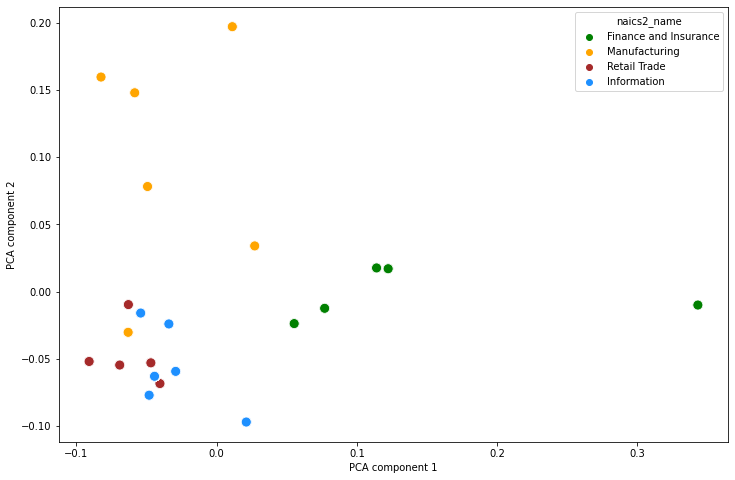

In [44]:
# PCA plot
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_plot, x="pca1", y="pca2", 
                hue="naics2_name", s=100,
                palette=['green','orange','brown','dodgerblue'])

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()

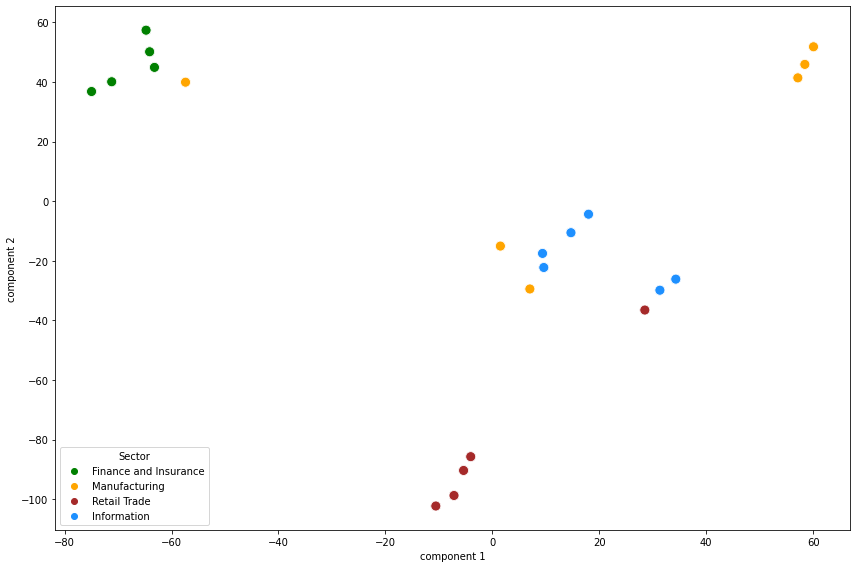

In [45]:
# t-SNE plot
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_plot, x="tsne1", y="tsne2",
                hue="naics2_name", s=100,
                palette=['green','orange','brown','dodgerblue'])

plt.xlabel("component 1")
plt.ylabel("component 2")
plt.tight_layout()
plt.legend(title="Sector",  fontsize="medium", fancybox=True)
plt.show()

In [46]:
# interactive 2D plot
fig = px.scatter(df_plot, x="tsne1", y="tsne2", color="naics2_name", hover_data=['cik', "firm_name"], color_discrete_sequence=['green','orange','brown','dodgerblue'])
fig

## Sentiment analysis

We will use a model trained on Twitter data to predict if a tweet had a negative, neutral or positive sentiment. The model is available through HuggingFace [here](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) and we will load it using: *cardiffnlp/twitter-roberta-base-sentiment*.

In [48]:
# generate sentiment prediction using a pipeline object for text classification
sentiment_classifier = pipeline(task="text-classification",                                 # define the task
                                model="cardiffnlp/twitter-roberta-base-sentiment",          # model should be appropriate for the task
                                tokenizer="cardiffnlp/twitter-roberta-base-sentiment",      # selected tokenizer
                                batch_size=16,                                              # batching only supported for GPUs
                                device=0,                                                   # -1 for CPU and 0 for GPU
                                framework="pt"                                              # data type 
                                )                

sentiment_classifier.task

'text-classification'

In [49]:
# classify all sequences (save their label and the score)
all_sentiment_labels = []
all_scores = []
for out in tqdm(sentiment_classifier(KeyDataset(dataset, "sentences"),
                                     truncation=True, 
                                     max_length=60,
                                     padding=False)):
    
    # FINBERT
    # extract the label and the score for each prediction
    # all_sentiment_labels.append(out["label"])
    # all_scores.append(out["score"])

    # Normal Sentiment
    # extract the label and the score for each prediction
    all_sentiment_labels.append(out["label"])
    all_scores.append(out["score"])

  0%|          | 0/431 [00:00<?, ?it/s]

In [50]:
# add predictions to dataframe
df["sentiment_label"] = all_sentiment_labels
df["sentiment_label_score"] = all_scores
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sentences,cik,year,sent_no,sent_id,naics2,sentence_len,keep_sent,sentiment_label,sentiment_label_score
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,132,True,LABEL_1,0.770769
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,133,True,LABEL_0,0.656604
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,389,True,LABEL_0,0.733676
3,Regulatory,19617,2019,3,19617_3,52,10,True,LABEL_1,0.658946
4,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,165,True,LABEL_1,0.765478
...,...,...,...,...,...,...,...,...,...,...
6876,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,132,True,LABEL_1,0.943793
6877,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,154,True,LABEL_0,0.579556
6878,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,102,True,LABEL_0,0.585249
6879,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,147,True,LABEL_0,0.583103


In [55]:
# search for the sentences with the highest negative scores (LABEL_0)
df_neg = df.loc[df["sentiment_label"] == "LABEL_0"].copy()
df_neg.sort_values("sentiment_label_score", ascending=False, inplace=True)

N = 5
for i, (idx, row) in enumerate(df_neg.iterrows()):
    if i < N:
        print(f"[Score {np.round(row['sentiment_label_score'], 3)}]:  ", row["sentences"])
        print("--------------------\n\n")

[Score 0.955]:   Component defects could make the Company's products unsafe and create a risk of environmental or property damage and personal injury.
--------------------


[Score 0.955]:   If our reputation or brand is damaged, our customers may refuse to continue shopping with us, potential employees may be unwilling to work for us, business partners may be discouraged from seeking future business dealings with us and, as a result, our operations and financial results may suffer.
--------------------


[Score 0.949]:   As a result, the Company's services may not perform as anticipated and may not meet customer expectations.
--------------------


[Score 0.948]:   Our products and services may contain undetected software errors, which could harm our business and operating results.
--------------------


[Score 0.947]:   Our software is highly complex and may contain undetected errors, defects or vulnerabilities, each of which could harm our business and financial performance.
-------

In [56]:
# search for the sentences with the highest positive scores (LABEL_2)
df_pos = df.loc[df["sentiment_label"] == "LABEL_2"].copy()
df_pos.sort_values("sentiment_label_score", ascending=False, inplace=True)

N = 5
for i, (idx, row) in enumerate(df_pos.iterrows()):
    if i < N:
        print(f"[Score {np.round(row['sentiment_label_score'], 3)}]:  ", row["sentences"])
        print("--------------------\n")

[Score 0.97]:   Our brands, particularly the FOX brand, are among our most valuable assets.
--------------------

[Score 0.961]:   Our strong brands have significantly contributed to the success of our business.
--------------------

[Score 0.961]:   We believe that our brand image, brand awareness and reputation strengthen our relationship with consumers and contribute significantly to the success of our business.
--------------------

[Score 0.959]:   Our success will depend largely on our ability to remain a technology leader and continue to provide high-quality, innovative products and services that are truly useful and play a meaningful role in people's everyday lives.
--------------------

[Score 0.949]:   In addition, we believe that our corporate culture fosters innovation, creativity, and teamwork.
--------------------



# Interpretatbility

Finally, we will show one possible strategy for gaining intuitions into how to interpret the model. This technique is known as [Shap](https://github.com/slundberg/shap) for *SHapley Additive exPlanations*. We will keep using the model for sentiment analysis shown in the previous section.

In [57]:
# initialize and explainer for a particular pipeline
explainer = shap.Explainer(sentiment_classifier)
explainer

In [72]:
shap_values = explainer(["We are very optimistic regarding the wonderful future that lies ahead for this company."])
shap_values

.values =
array([[[ 0.00000000e+00,  1.86264515e-09, -1.49011612e-08],
        [ 0.00000000e+00, -5.89251276e-02,  1.23766862e-01],
        [ 0.00000000e+00, -4.43893354e-02,  6.22650124e-02],
        [ 0.00000000e+00, -4.19521239e-02,  7.51911588e-02],
        [ 0.00000000e+00, -1.02343427e-01,  2.35444773e-01],
        [ 0.00000000e+00,  1.14645762e-01, -1.90073099e-01],
        [ 0.00000000e+00,  3.27062812e-02, -2.71011405e-02],
        [ 0.00000000e+00, -1.90275202e-01,  3.11903495e-01],
        [-3.00474484e-02, -2.84991972e-03,  5.85692339e-02],
        [-3.00474484e-02,  7.61514623e-02, -2.97632702e-02],
        [ 5.86361568e-02, -1.29403284e-01,  8.56424086e-02],
        [-1.18731054e-01,  5.17973248e-02,  8.66655372e-02],
        [-1.81494569e-02, -3.29253273e-02,  7.34923854e-02],
        [ 4.81969053e-02, -9.44332685e-03, -5.20622302e-02],
        [ 3.00474484e-02, -1.80555910e-01,  1.77478792e-01],
        [ 6.00948967e-02, -6.33041896e-02, -6.28463924e-04],
        [ 0.00

In [73]:
# visualize the explanation for the POSITIVE (label_2) output class
shap.plots.text(shap_values[0, :, "LABEL_2"])

In [79]:
# Analyze multiple sentences
shap_values = explainer(df["sentences"].sample(50))

Partition explainer: 51it [01:16,  1.70s/it]


/usr/local/lib/python3.7/dist-packages/slicer/slicer_internal.py:443: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



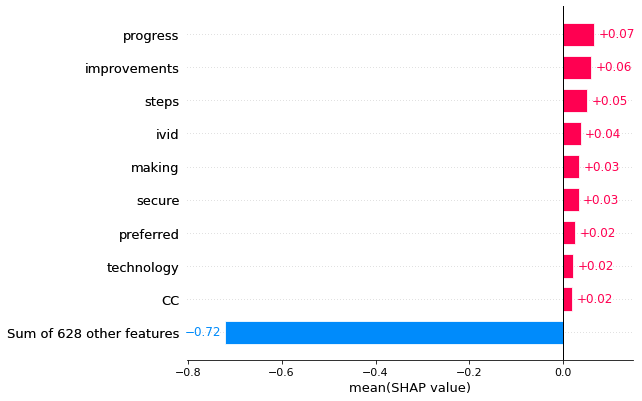

In [80]:
# words that more strongly explain a positve label
shap.plots.bar(shap_values[:,:,"LABEL_2"].mean(0), order=shap.Explanation.argsort.flip)

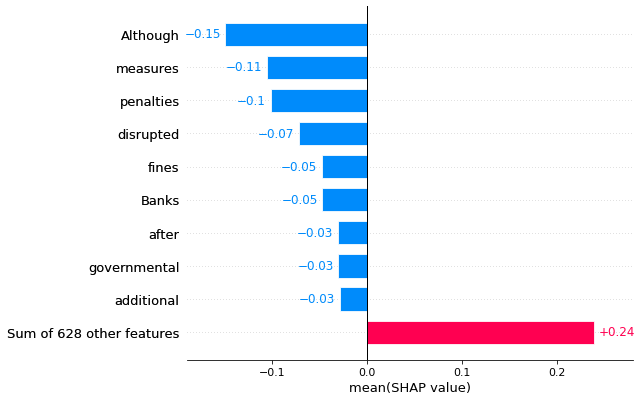

In [81]:
# words that impact negatively a postive label
shap.plots.bar(shap_values[:,:,"LABEL_2"].mean(0), order=shap.Explanation.argsort)